In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [2]:
import torch
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import random
from src.useful_functions import *

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = torch.distributions.uniform.Uniform(-math.pi,math.pi)
#p_x = torch.distributions.exponential.Exponential(0.5)
#p_x = torch.distributions.uniform.Uniform(0,15)
#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

In [4]:
sigmas = (torch.ones(N)*2*np.pi/(N))[None,:]
log_ks = torch.log(1/sigmas)
As = torch.exp(-torch.exp(log_ks))*torch.ones(N)[None,:]

sigmas
log_ks
As

tensor([[0.2036, 0.2036, 0.2036, 0.2036, 0.2036, 0.2036, 0.2036, 0.2036, 0.2036,
         0.2036]])

Text(0, 0.5, 'Encoding')

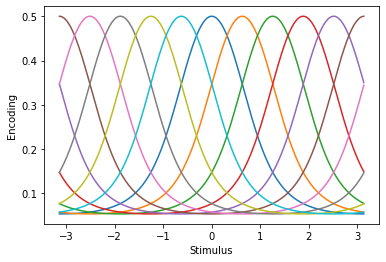

In [4]:
#CIRCULAR ENCODER/DECODER TRY
enc_circ = CircularBernoulliEncoder(N)
dec = MLPDecoder(N,200)
r = enc_circ.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)

plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")


#TO DO: circular decoder with von mises circular distribution + circular rate

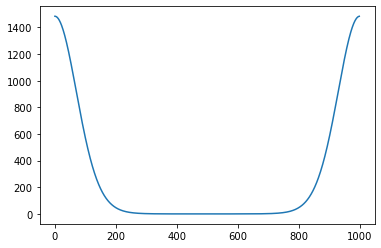

In [5]:
r = enc_circ.sample(x_fine,10)
a = 10
theta = torch.as_tensor(math.pi)
k = 5
func = a*torch.exp(k*torch.cos(x_fine - theta))
plt.plot(func)



In [6]:
class ModifiedBessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, k, nu):
        ctx._nu = nu
        ctx.save_for_backward(k)
        return torch.from_numpy(scipy.special.iv(nu, k.detach().numpy()))
    @staticmethod
    def backward(ctx, grad_out):
        k, = ctx.saved_tensors
        nu = ctx._nu
        
        return 0.5* grad_out *(ModifiedBessel.apply(k, nu - 1.0)+ModifiedBessel.apply(k, nu + 1.0)), None




modified_bessel = ModifiedBessel.apply



In [23]:
x = torch.randn(5, requires_grad=True, dtype=torch.float64)
torch.autograd.gradcheck(lambda x: modified_bessel(x, 0.0), (x,))




l_r_x = enc_circ(x_fine)
bsize,N = l_r_x.shape
#ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
eps = torch.rand(bsize,10,N)
r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/0.5)
mu_dec,sigma2_dec = dec(r)
k = (1/sigma2_dec)

#modified_bessel(k,0)

l_r_x

tensor([[0.3142, 0.3905, 0.6953,  ..., 1.4383, 0.7032, 0.3933],
        [0.3142, 0.3889, 0.6905,  ..., 1.4483, 0.7081, 0.3950],
        [0.3142, 0.3873, 0.6858,  ..., 1.4582, 0.7130, 0.3967],
        ...,
        [0.3142, 0.3980, 0.7166,  ..., 1.3955, 0.6824, 0.3861],
        [0.3142, 0.3962, 0.7116,  ..., 1.4052, 0.6871, 0.3877],
        [0.3142, 0.3945, 0.7067,  ..., 1.4150, 0.6918, 0.3894]],
       grad_fn=<AddBackward0>)

In [7]:
def distortion_circular(x,encoder,decoder,lat_samp=10,tau=0.5):
    #Logit r|x
    l_r_x = encoder(x)
    bsize,N = l_r_x.shape
    #ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
    eps = torch.rand(bsize,lat_samp,N)
    r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/tau)
    mu_dec,sigma2_dec = decoder(r)
    k = (1/sigma2_dec).detach()
    logq_x_r = k*torch.cos(x-mu_dec) - modified_bessel(k,0) - torch.log(2*torch.as_tensor(math.pi))
    D = -logq_x_r.mean()
    return D

#scipy.special.iv(0,k) = modified Bessel function of the first kind of order 0


In [8]:
enc_circ = CircularBernoulliEncoder(N)
l_r_x = enc_circ(x_fine)
dec = MLPDecoder(N,200)
params = enc_circ.parameters()
opt = torch.optim.Adam(params,lr)

loss = distortion_circular(x_fine,enc_circ,dec)
opt.zero_grad()
loss.backward()
opt.step()

In [10]:
l_r_x = enc_circ(x_fine)
l_r_x

tensor([[0.3210, 0.3817, 0.7018,  ..., 1.4127, 0.7056, 0.3821],
        [0.3210, 0.3801, 0.6971,  ..., 1.4226, 0.7104, 0.3838],
        [0.3210, 0.3785, 0.6925,  ..., 1.4326, 0.7152, 0.3856],
        ...,
        [0.3217, 0.3970, 0.7453,  ..., 1.3266, 0.6652, 0.3677],
        [0.3216, 0.3952, 0.7403,  ..., 1.3361, 0.6695, 0.3692],
        [0.3214, 0.3935, 0.7353,  ..., 1.3456, 0.6740, 0.3708]],
       grad_fn=<AddBackward0>)

In [11]:
log_ks = enc_circ.log_ks
log_ks

Parameter containing:
tensor([[1.1679, 1.1479, 1.1479, 1.1479, 1.1479, 1.1479, 1.1479, 1.1679, 1.1479,
         1.1679]], requires_grad=True)

In [12]:
As = enc_circ.As
As

Parameter containing:
tensor([[1.0100, 0.9900, 1.0100, 1.0100, 1.0100, 1.0100, 1.0100, 0.9900, 1.0100,
         0.9900]], requires_grad=True)

In [13]:
cs = enc_circ.cs
cs

Parameter containing:
tensor([[0.0100, 0.6183, 1.2466, 1.8950, 2.5233, 3.1316, 3.7599, 4.4082, 5.0365,
         5.6449]], requires_grad=True)

In [14]:
etas = torch.exp((log_ks)*torch.cos(x_fine - cs)) + torch.log(As)
etas

tensor([[0.3210, 0.3817, 0.7018,  ..., 1.4127, 0.7056, 0.3821],
        [0.3210, 0.3801, 0.6971,  ..., 1.4226, 0.7104, 0.3838],
        [0.3210, 0.3785, 0.6925,  ..., 1.4326, 0.7152, 0.3856],
        ...,
        [0.3217, 0.3970, 0.7453,  ..., 1.3266, 0.6652, 0.3677],
        [0.3216, 0.3952, 0.7403,  ..., 1.3361, 0.6695, 0.3692],
        [0.3214, 0.3935, 0.7353,  ..., 1.3456, 0.6740, 0.3708]],
       grad_fn=<AddBackward0>)

In [11]:
for e in range(100):
    loss = distortion_circular(x_fine,enc_circ,dec)
    #print(modified_bessel(k,0))
    #print(loss)
    #print(loss.grad)
    print(enc_circ.As)
    
    opt.zero_grad()
    loss.backward()
    opt.step()

Parameter containing:
tensor([[1.0100, 0.9900, 1.0100, 0.9900, 1.0100, 1.0100, 1.0100, 1.0100, 0.9900,
         1.0100]], requires_grad=True)
Parameter containing:
tensor([[1.0200, 0.9800, 1.0197, 0.9800, 1.0200, 1.0200, 1.0200, 1.0200, 0.9800,
         1.0200]], requires_grad=True)
Parameter containing:
tensor([[1.0300, 0.9700, 1.0296, 0.9700, 1.0298, 1.0299, 1.0300, 1.0300, 0.9700,
         1.0299]], requires_grad=True)
Parameter containing:
tensor([[1.0400, 0.9600, 1.0395, 0.9600, 1.0397, 1.0397, 1.0399, 1.0399, 0.9599,
         1.0398]], requires_grad=True)
Parameter containing:
tensor([[1.0500, 0.9500, 1.0494, 0.9499, 1.0496, 1.0497, 1.0497, 1.0499, 0.9498,
         1.0497]], requires_grad=True)
Parameter containing:
tensor([[1.0599, 0.9400, 1.0593, 0.9399, 1.0595, 1.0595, 1.0596, 1.0598, 0.9397,
         1.0595]], requires_grad=True)
Parameter containing:
tensor([[1.0698, 0.9299, 1.0692, 0.9298, 1.0693, 1.0694, 1.0694, 1.0698, 0.9296,
         1.0692]], requires_grad=True)
Parame

In [9]:
 distortion_circular(x_fine,enc_circ,dec)

tensor(3.0259, grad_fn=<NegBackward>)

In [10]:
l_r_x = enc_circ(x_fine)
bsize,N = l_r_x.shape
#ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
eps = torch.rand(bsize,10,N)
r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/0.5)
mu_dec,sigma2_dec = dec(r)
k = (1/sigma2_dec).detach()
mp = mu_dec*k
logq_x_r = k*torch.cos(x_fine-mu_dec) - torch.log(2*torch.as_tensor(math.pi))  - torch.log(scipy.special.kn(0,k))
#D = -logq_x_r.mean()
#D

#mu_dec




In [10]:
q = rate_ising(N)
loss = q(enc_circ,x_fine)
dist = distortion_circular(x_fine,enc_circ,dec)

In [9]:
ciao = scipy.special.kn(0,5)
#r = enc_circ.sample(x_fine,10)

In [11]:
#Traning on the entire set of parameters
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(enc_circ.parameters(),dec.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        #rate = q(enc_circ,x_)
        dist = distortion_circular(x_,enc_circ,dec)
        loss = dist
        print(dist)
    
        opt.zero_grad()
        loss.backward()
        
        opt.step()
        lossVec.append(loss.item())
        #rateVec.append(rate.item())
        #distVec.append(dist.item())
        

tensor(3.0469, grad_fn=<NegBackward>)
tensor(3.0420, grad_fn=<NegBackward>)
tensor(3.0392, grad_fn=<NegBackward>)
tensor(3.0318, grad_fn=<NegBackward>)
tensor(3.0259, grad_fn=<NegBackward>)
tensor(3.0223, grad_fn=<NegBackward>)
tensor(3.0174, grad_fn=<NegBackward>)
tensor(3.0136, grad_fn=<NegBackward>)
tensor(3.0058, grad_fn=<NegBackward>)
tensor(3.0020, grad_fn=<NegBackward>)
tensor(2.9956, grad_fn=<NegBackward>)
tensor(2.9929, grad_fn=<NegBackward>)
tensor(2.9868, grad_fn=<NegBackward>)
tensor(2.9816, grad_fn=<NegBackward>)
tensor(2.9730, grad_fn=<NegBackward>)
tensor(2.9699, grad_fn=<NegBackward>)
tensor(2.9626, grad_fn=<NegBackward>)
tensor(2.9571, grad_fn=<NegBackward>)
tensor(2.9491, grad_fn=<NegBackward>)
tensor(2.9431, grad_fn=<NegBackward>)
tensor(2.9378, grad_fn=<NegBackward>)
tensor(2.9298, grad_fn=<NegBackward>)
tensor(2.9248, grad_fn=<NegBackward>)
tensor(2.9168, grad_fn=<NegBackward>)
tensor(2.9108, grad_fn=<NegBackward>)
tensor(2.9084, grad_fn=<NegBackward>)
tensor(2.896

In [24]:
#params = itertools.chain(enc_circ.parameters(),dec.parameters())
params = list(dec.parameters()) + list(enc_circ.parameters()) +
lr = 1e-3
opt = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    dist = distortion_circular(x_fine,enc_circ,dec)
    loss = dist
    print(dist)
    #print(params.grad)
    
    opt.zero_grad()
    #loss.retain_grad()
    loss.backward()
        
    opt.step()
    #print(loss.grad)
    

tensor(2.9789, grad_fn=<NegBackward>)
tensor(2.9801, grad_fn=<NegBackward>)
tensor(2.9807, grad_fn=<NegBackward>)
tensor(2.9807, grad_fn=<NegBackward>)
tensor(2.9806, grad_fn=<NegBackward>)
tensor(2.9804, grad_fn=<NegBackward>)
tensor(2.9805, grad_fn=<NegBackward>)
tensor(2.9809, grad_fn=<NegBackward>)
tensor(2.9815, grad_fn=<NegBackward>)
tensor(2.9821, grad_fn=<NegBackward>)
tensor(2.9829, grad_fn=<NegBackward>)
tensor(2.9835, grad_fn=<NegBackward>)
tensor(2.9842, grad_fn=<NegBackward>)
tensor(2.9848, grad_fn=<NegBackward>)
tensor(2.9852, grad_fn=<NegBackward>)
tensor(2.9858, grad_fn=<NegBackward>)
tensor(2.9865, grad_fn=<NegBackward>)
tensor(2.9875, grad_fn=<NegBackward>)
tensor(2.9888, grad_fn=<NegBackward>)
tensor(2.9899, grad_fn=<NegBackward>)
tensor(2.9911, grad_fn=<NegBackward>)
tensor(2.9922, grad_fn=<NegBackward>)
tensor(2.9932, grad_fn=<NegBackward>)
tensor(2.9938, grad_fn=<NegBackward>)
tensor(2.9942, grad_fn=<NegBackward>)
tensor(2.9946, grad_fn=<NegBackward>)
tensor(2.995

Text(0, 0.5, 'Encoding')

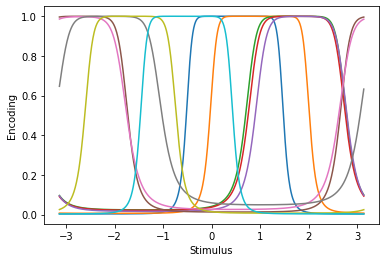

In [12]:
plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

NameError: name 'lossVec' is not defined

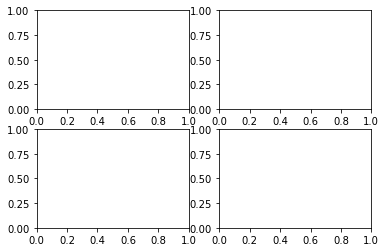

In [19]:
r = enc_circ.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()